# **Question 1**

In [1]:
import numpy as np

# 1. XOR gate truth table dataset

In [5]:
X = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]])

y = np.array([0, 1, 1, 0])

# 2. Implementing Single Layer Perceptron

In [6]:
class Perceptron:
    def __init__(self, learning_rate=0.1, epochs=100):
        self.learning_rate = learning_rate
        self.epochs = epochs

    def activation(self, x):
        return 1 if x >= 0 else 0

    def train(self, X, y):
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)
        self.bias = 0

        for _ in range(self.epochs):
                for i in range(num_samples):
                    linear_output = np.dot(X[i], self.weights) + self.bias
                    y_pred = self.activation(linear_output)
                    update = self.learning_rate * (y[i] - y_pred)
                    self.weights += update * X[i]
                    self.bias += update

    def predict(self, X):
        linear_output = np.dot(X, self.weights) + self.bias
        return np.array([self.activation(x) for x in linear_output])

# 3. Training the single layer perceptron on XOR gate


In [7]:
perceptron = Perceptron(learning_rate=0.1, epochs=10)
perceptron.train(X, y)

y_pred = perceptron.predict(X)
print("Predicted Outputs: ", y_pred)
print("Actual Outputs: ", y)

accuracy = np.sum(y_pred == y) / len(y) * 100
print(f"Accuracy of Single Layer Perceptron on XOR data: {accuracy}%")

Predicted Outputs:  [1 1 0 0]
Actual Outputs:  [0 1 1 0]
Accuracy of Single Layer Perceptron on XOR data: 50.0%


# 4. Observation for Single Layer Perceptron

The perceptron achieved 50% accuracy, correctly predicting only two of the four cases. This happens because the XOR problem is non-linearly separable, and a single-layer perceptron can only handle linear decision boundaries. As a result, it fails to classify the cases where the inputs differ ([0,1] and [1,0]). This highlights the perceptron's limitation in solving non-linear problems like XOR.

# 5. Implementaton of XOR using Multilevel Perceptron

In [30]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

mlp = MLPClassifier(hidden_layer_sizes=(2,), max_iter=10000, activation='relu', solver='adam')

mlp.fit(X, y)

y_pred_mlp = mlp.predict(X)

print("Predicted outputs (MLP):", y_pred_mlp)
print("Actual outputs:", y)

accuracy_mlp = accuracy_score(y, y_pred_mlp) * 100
print(f"Accuracy of Multi-Layer Perceptron on XOR data: {accuracy_mlp}%")

Predicted outputs (MLP): [0 1 1 0]
Actual outputs: [0 1 1 0]
Accuracy of Multi-Layer Perceptron on XOR data: 100.0%


# **Question 2**

In [45]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [33]:
df = pd.read_csv("tweets.csv")

# 1. Simple feed forward neural netwrok

In [35]:
# Encode 'airline_sentiment' as binary (positive = 1, negative = 0)
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['airline_sentiment'])

In [36]:
# Filter only positive and negative sentiments, excluding neutral
df = df[df['airline_sentiment'] != 'neutral']

In [37]:
# Extract text and labels
X = df['text'].values
y = df['label'].values

In [38]:
# Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(X).toarray()

In [39]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# 2. Backpropogation to optimize model weights

In [46]:
# Convert datasets to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [51]:
# Define the Neural Network class
class SentimentNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation_fn='relu'):
        super(SentimentNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

        if activation_fn == 'relu':
            self.activation = nn.ReLU()
        elif activation_fn == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation_fn == 'tanh':
            self.activation = nn.Tanh()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# 3. Experiment with different Activation Fucntions

In [50]:
# Function to train the model with backpropagation
def train_model(activation_fn, learning_rate=0.001, epochs=100):
    input_size = X_train.shape[1]
    hidden_size = 64
    output_size = 1

    # Initialize the model, loss function, and optimizer
    model = SentimentNet(input_size, hidden_size, output_size, activation_fn)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Lists to store loss for plotting
    loss_values = []

    # Training loop
    for epoch in range(epochs):
        # Forward pass: Compute predicted y by passing X to the model
        y_pred = model(X_train_tensor)

        # Compute loss
        loss = criterion(y_pred, y_train_tensor)

        # Zero gradients, perform a backward pass, and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Save the loss value for plotting
        loss_values.append(loss.item())

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    # Plot the loss curve
    plt.plot(loss_values, label=f'Activation: {activation_fn}')

    return model

In [48]:
# Evaluate the model on the test set
def evaluate_model(model):
    y_pred = model(X_test_tensor)
    y_pred = (y_pred > 0.5).float()

    # Calculate accuracy
    accuracy = accuracy_score(y_test_tensor, y_pred.detach().numpy())
    return accuracy

In [49]:
# List of activation functions to experiment with
activations = ['relu', 'sigmoid', 'tanh']

plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

# 4. Evaluate model and plot the loss

Epoch [10/100], Loss: 0.6451
Epoch [20/100], Loss: 0.6116
Epoch [30/100], Loss: 0.5721
Epoch [40/100], Loss: 0.5284
Epoch [50/100], Loss: 0.4831
Epoch [60/100], Loss: 0.4393
Epoch [70/100], Loss: 0.3986
Epoch [80/100], Loss: 0.3617
Epoch [90/100], Loss: 0.3289
Epoch [100/100], Loss: 0.3005
Accuracy with relu activation: 0.89
Epoch [10/100], Loss: 0.6172
Epoch [20/100], Loss: 0.5536
Epoch [30/100], Loss: 0.5197
Epoch [40/100], Loss: 0.5043
Epoch [50/100], Loss: 0.4976
Epoch [60/100], Loss: 0.4939
Epoch [70/100], Loss: 0.4908
Epoch [80/100], Loss: 0.4877
Epoch [90/100], Loss: 0.4844
Epoch [100/100], Loss: 0.4811
Accuracy with sigmoid activation: 0.81
Epoch [10/100], Loss: 0.6359
Epoch [20/100], Loss: 0.5732
Epoch [30/100], Loss: 0.5131
Epoch [40/100], Loss: 0.4638
Epoch [50/100], Loss: 0.4283
Epoch [60/100], Loss: 0.4020
Epoch [70/100], Loss: 0.3792
Epoch [80/100], Loss: 0.3573
Epoch [90/100], Loss: 0.3360
Epoch [100/100], Loss: 0.3157
Accuracy with tanh activation: 0.87


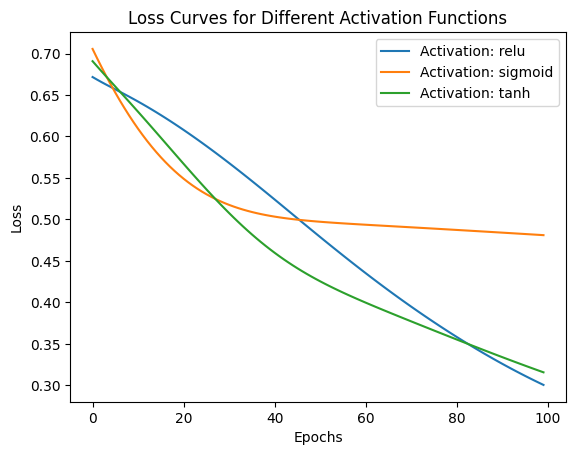

In [52]:
# Train and evaluate the model for each activation function
for activation in activations:
    model = train_model(activation_fn=activation, learning_rate=0.001, epochs=100)
    accuracy = evaluate_model(model)
    print(f"Accuracy with {activation} activation: {accuracy:.2f}")

# Customize and show the loss curve plot
plt.title('Loss Curves for Different Activation Functions')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

ReLU clearly outperforms both Sigmoid and Tanh in terms of loss minimization and convergence speed.
Sigmoid appears to be the least efficient for this particular task, likely due to issues like vanishing gradients, which can slow down learning.
Tanh performs moderately well but is still not as effective as ReLU.

ReLU seems to be the most suitable activation function for this dataset compared to other two activation functions.